# Import Libraries

In [1]:
import pandas as pd 
import numpy as np 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
%matplotlib inline
import pandas as pd 
from tabulate import tabulate
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo

In [2]:
train1 = pd.read_csv('train_month_3_with_target.csv')
train2 = pd.read_csv('train_month_2.csv')
train3 = pd.read_csv('train_month_1.csv')
test1 = pd.read_csv('test_month_3.csv')
test2 = pd.read_csv('test_month_2.csv')
test3 = pd.read_csv('test_month_1.csv')

## Dataset type info

In [3]:
#train1.info()
train1.describe()
train1.isna().any()
train1.dtypes

client_id                             object
homebanking_active                     int64
has_homebanking                        int64
has_insurance_21                       int64
has_insurance_23                       int64
has_life_insurance_fixed_cap           int64
has_life_insurance_decreasing_cap      int64
has_fire_car_other_insurance           int64
has_personal_loan                      int64
has_mortgage_loan                      int64
has_current_account                    int64
has_pension_saving                     int64
has_savings_account                    int64
has_savings_account_starter            int64
has_current_account_starter            int64
bal_insurance_21                       int64
bal_insurance_23                       int64
cap_life_insurance_fixed_cap           int64
cap_life_insurance_decreasing_cap      int64
prem_fire_car_other_insurance          int64
bal_personal_loan                      int64
bal_mortgage_loan                      int64
bal_curren

In [4]:
train1['customer_since_all'] = pd.to_datetime(train1['customer_since_all'])
train1['customer_since_bank'] = pd.to_datetime(train1['customer_since_bank'])
train1['customer_birth_date'] = pd.to_datetime(train1['customer_birth_date'])

cat_vars = []
cont_vars = []
columns = list(train1.drop(columns = ['client_id']).columns)
for i in columns:
    if (len(train1.loc[:,i].unique()) >= 20):
        cont_vars.append(i)
    else:
        cat_vars.append(i)
        
print('Continious variables are:',cont_vars)
print('------------------')
print('Categorical variables are:',cat_vars)
# Here we have our list of categorical and continious variables

Continious variables are: ['bal_insurance_21', 'bal_insurance_23', 'cap_life_insurance_fixed_cap', 'cap_life_insurance_decreasing_cap', 'prem_fire_car_other_insurance', 'bal_personal_loan', 'bal_mortgage_loan', 'bal_current_account', 'bal_pension_saving', 'bal_savings_account', 'bal_savings_account_starter', 'bal_current_account_starter', 'customer_since_all', 'customer_since_bank', 'customer_birth_date', 'customer_postal_code']
------------------
Categorical variables are: ['homebanking_active', 'has_homebanking', 'has_insurance_21', 'has_insurance_23', 'has_life_insurance_fixed_cap', 'has_life_insurance_decreasing_cap', 'has_fire_car_other_insurance', 'has_personal_loan', 'has_mortgage_loan', 'has_current_account', 'has_pension_saving', 'has_savings_account', 'has_savings_account_starter', 'has_current_account_starter', 'visits_distinct_so', 'visits_distinct_so_areas', 'customer_gender', 'customer_occupation_code', 'customer_self_employed', 'customer_education', 'customer_children', 

### Categorical features unique values

In [5]:
# To check we will print all unique values
for col in cat_vars:
    print(col,train1[col].unique())

homebanking_active [0 1]
has_homebanking [0 1]
has_insurance_21 [0 1]
has_insurance_23 [0 1]
has_life_insurance_fixed_cap [0 1]
has_life_insurance_decreasing_cap [0 1]
has_fire_car_other_insurance [1 0]
has_personal_loan [0 1]
has_mortgage_loan [0 1]
has_current_account [1 0]
has_pension_saving [0 1]
has_savings_account [1 0]
has_savings_account_starter [0 1]
has_current_account_starter [0 1]
visits_distinct_so [1. 2. 3. 4. 6. 5. 7.]
visits_distinct_so_areas [1. 2. 3. 5. 4. 6.]
customer_gender [1 2]
customer_occupation_code [ 9. nan  7.  8.  4.  5.  0.  6.  3.  1.  2.]
customer_self_employed [0 1]
customer_education [ 0. nan  2.  1.  4.  3.  5.  6.]
customer_children [nan 'mature' 'no' 'young' 'preschool' 'adolescent' 'grownup' 'onebaby'
 'yes']
customer_relationship [nan 'couple' 'single']
target [0 1]


### Colums with missing Data

In [6]:
missing_df = train1.isnull().sum(axis=0).reset_index()
missing_df.columns = ['variable', 'missing values']
missing_df['%']=(missing_df['missing values'])/train1.shape[0]*100
missing_df = missing_df[missing_df['missing values'] >0].sort_values('%')
missing_df

,variable,missing values,%
29,customer_since_all,234,0.367364
30,customer_since_bank,249,0.390913
34,customer_occupation_code,2002,3.143005
38,customer_relationship,14899,23.390427
37,customer_children,23364,36.679906
36,customer_education,47125,73.983076


We will explore the following columns to see how can we deal with the missing values:
-    customer_education
-    customer_occupation_code
-    customer_relationship
-    customer_children



In [ ]:
missing_df2 = missing_df[missing_df['missing values'] >250]
for col in missing_df2['variable']:
    print(col,train1[col].unique())

customer_education

In [ ]:
sns.countplot(x='customer_education',data=train1,hue='target',palette="coolwarm_r")

### customer_occupation_code 
-   Most of the clients's job code is equal to 9.
-   From the plot above, we can't see a direct relationship between job code and current balance.\
-> customer_occupation_code feature will be dropped.

In [ ]:
for x in range(0,10):
    print(f'job_code {x}', len(train1.loc[(train1['customer_occupation_code']==x)]))

In [ ]:
sns.countplot(x='customer_occupation_code',data=train1,hue='target',palette="coolwarm_r")

In [ ]:
plt.scatter(train1['customer_occupation_code'], train1['bal_current_account'])

### customer_relationship 
Among the non-missing data, the table below describes the proportion of customers churned if they are single or in a couple. 
We have approxiatemtly the same proportion of churners whether they are a couple or single. 

In [ ]:
a = len(train1.loc[(train1['customer_relationship']=='couple') & (train1['target']== 0)])+len(train1.loc[(train1['customer_relationship']=='couple') & (train1['target']== 1)]) 

b = len(train1.loc[(train1['customer_relationship']=='single') & (train1['target']== 0)])+ len(train1.loc[(train1['customer_relationship']=='single') & (train1['target']== 1)]) 
table=[['Relationship','0','1'],
        [str(len(train1.loc[(train1['customer_relationship']=='couple')])) + ' Couple',round(len(train1.loc[(train1['customer_relationship']=='couple') & (train1['target']== 0)])/a,2 ),round(len(train1.loc[(train1['customer_relationship']=='couple') & (train1['target']== 1)])/a,2) ],
        [str(len(train1.loc[(train1['customer_relationship']=='single')])) + ' Single',round(len(train1.loc[(train1['customer_relationship']=='single') & (train1['target']== 0)])/b,2) ,round(len(train1.loc[(train1['customer_relationship']=='single') & (train1['target']== 1)])/b,2) ]]
print(tabulate(table, headers='firstrow'))

### customer_children

In [ ]:
rep = {'mature':1,'no':0, 'young':1,'preschool':1,'adolescent':1,'grownup':1,'onebaby':1
 ,'yes':1}
train1['customer_children']= train1['customer_children'].replace(rep) 

In [ ]:
c = len(train1.loc[(train1['customer_children']==0) & (train1['target']== 0)])+len(train1.loc[(train1['customer_children']==0) & (train1['target']== 1)]) 

d = len(train1.loc[(train1['customer_children']==1) & (train1['target']== 0)])+ len(train1.loc[(train1['customer_children']==1) & (train1['target']== 1)]) 
table=[['Children','0','1'],
        [str(len(train1.loc[(train1['customer_children']==0)])) + ' Without kids',round(len(train1.loc[(train1['customer_children']==0) & (train1['target']== 0)])/c,2 ),round(len(train1.loc[(train1['customer_children']==0) & (train1['target']== 1)])/c,2) ],
        [str(len(train1.loc[(train1['customer_children']==1)])) + ' With kids',round(len(train1.loc[(train1['customer_children']==1) & (train1['target']== 0)])/d,2) ,round(len(train1.loc[(train1['customer_children']==1) & (train1['target']== 1)])/d,2) ]]
print(tabulate(table, headers='firstrow'))

In [ ]:
sns.countplot(x='customer_children',data=train1,hue='target',palette="coolwarm_r")

ppl w/o home banking active tend to churn less. is there a diff between that and has_homebanking? 
insurance 21 or 23 -> if not then don't churn, noone who has it churned? 
fixed insurance cap, very low amount of ppl have it. 
decreasing cap seems interesting. 
fire car insurance interesting.
not many ppl w personal loan, same for mortgage. 
current account seems to have effect on churn 
no churn if pension savings.
gender does seems to have a low effect on churn. 
more chrun if occupation code =9
seems like having children might have an effect but have to reformat that var. 
ppl in couple seem to churn more.

# Data pre-processing

In [7]:
train1 = pd.read_csv('train_month_3_with_target.csv')
train2 = pd.read_csv('train_month_2.csv')
train3 = pd.read_csv('train_month_1.csv')
test1 = pd.read_csv('test_month_3.csv')
test2 = pd.read_csv('test_month_2.csv')
test3 = pd.read_csv('test_month_1.csv')

In [8]:
df_list=[train1,train2,train3,test1,test2,test3]

## Remove columns and transform date columns

In [9]:
def drop_col(x):
    x.drop(['customer_children','customer_relationship','customer_occupation_code','customer_education',],axis=1, inplace=True) 
    x.dropna(axis=0, inplace=True) 

In [10]:
def striptime(x):
    x['customer_since_all'] = pd.to_datetime(x['customer_since_all'])
    x['customer_since_bank'] = pd.to_datetime(x['customer_since_bank'])
    x['customer_birth_date'] = pd.to_datetime(x['customer_birth_date'])
    x['Birth_year'] = x['customer_birth_date'].dt.strftime('%Y').astype(str).astype(int)
    x['Year_since_all'] = x['customer_since_all'].dt.strftime('%Y').astype(str).astype(int)
    x['Month_since_all'] = x['customer_since_all'].dt.strftime('%m').astype(str).astype(int)
    x['Year_since_bank'] = x['customer_since_bank'].dt.strftime('%Y').astype(str).astype(int)
    x['Month_since_bank'] = x['customer_since_bank'].dt.strftime('%m').astype(str).astype(int)
    x.drop(['customer_since_all','customer_since_bank','customer_birth_date'], axis=1, inplace=True)



In [11]:
for x in df_list:
    drop_col(x)
    striptime(x)
    print(x.shape)




(63448, 38)
(63448, 37)
(63448, 37)
(27183, 37)
(27183, 37)
(27183, 37)


## Removing outliers

We have noticed some of the clients are born in the 80s. Therefore we will assign a threshhold of 100years for the client's age.  In addition, the client's birth year cannot greater than the year he started using the banks services.

In [12]:
def remove_out(x):
    x.drop(x[x['Birth_year'] < 1919].index, inplace = True)
    x.drop(x.loc[x['Birth_year'] > (x['Year_since_all'] | x['Year_since_bank'])].index, inplace=True)

remove_out(train1)
remove_out(train2)
remove_out(train3)
remove_out(test1)
remove_out(test2)
remove_out(test3)

# EDA

## Feature Engineering

First, let's extract the customer's Age and drop Birth_year

In [13]:
def client_age(x):
    x['Age'] = x['Birth_year'].apply(lambda x: 2018 -x)
    x.drop('Birth_year', axis=1, inplace=True)
    
for x in df_list:
    client_age(x)

- We could see if there is a significant (large) difference in say balance or savings as this could be an indicator that the client is about to churn. (can just be stored as a boolean). 
- can also compute a boolean regarding the change in some services that the client has. Say he dropped in insurrance 21 last month or smtg. also as a boolean 

In [14]:
#creates a new column in the dataset with a boolean regarding if the values between the 3 columns are the same. 

def bool_change(orig1,orig2,orig3, cols,key ='client_id'):
    columns= [key] + cols 
    merged = pd.merge(orig1,orig2[columns], how = 'left',on = key, suffixes=['','-1'])
    merged = pd.merge(merged,orig3[columns], how = 'left',on = key, suffixes=['','-2'])
    to_drop =[]
    for var in cols:
        merged['ch_{}'.format(var)] = np.where((merged[var]==merged['{}-1'.format(var)])&(
                                   merged[var] == merged['{}-2'.format(var)]),0,1)
        to_drop+=['{}-1'.format(var),'{}-2'.format(var)]
    merged.drop(to_drop,axis=1,inplace=True)
    return merged

In [15]:
# create a new column regarding if there was a change in any var that starts w has_... in the last couple months
# will be 1 if there was any change in the last 2 months 0 otherwise
to_bool = ['homebanking_active', 'has_homebanking',
       'has_insurance_21', 'has_insurance_23', 'has_life_insurance_fixed_cap',
       'has_life_insurance_decreasing_cap', 'has_fire_car_other_insurance',
       'has_personal_loan', 'has_mortgage_loan', 'has_current_account',
       'has_pension_saving', 'has_savings_account',
       'has_savings_account_starter', 'has_current_account_starter']
train_s = bool_change(train1,train2,train3, to_bool)
train_s.columns

Index(['client_id', 'homebanking_active', 'has_homebanking',
       'has_insurance_21', 'has_insurance_23', 'has_life_insurance_fixed_cap',
       'has_life_insurance_decreasing_cap', 'has_fire_car_other_insurance',
       'has_personal_loan', 'has_mortgage_loan', 'has_current_account',
       'has_pension_saving', 'has_savings_account',
       'has_savings_account_starter', 'has_current_account_starter',
       'bal_insurance_21', 'bal_insurance_23', 'cap_life_insurance_fixed_cap',
       'cap_life_insurance_decreasing_cap', 'prem_fire_car_other_insurance',
       'bal_personal_loan', 'bal_mortgage_loan', 'bal_current_account',
       'bal_pension_saving', 'bal_savings_account',
       'bal_savings_account_starter', 'bal_current_account_starter',
       'visits_distinct_so', 'visits_distinct_so_areas', 'customer_gender',
       'customer_postal_code', 'customer_self_employed', 'target',
       'Year_since_all', 'Month_since_all', 'Year_since_bank',
       'Month_since_bank', 'Age', 'c

In [17]:
#check if df is factorable 
train_fa = train_s.drop(['client_id','target'],axis=1)
chi_square_value,p_value=calculate_bartlett_sphericity(train_fa)
chi_square_value, p_value

(1053544.6589014262, 0.0)

In [18]:
_,kmo_model=calculate_kmo(train_fa)

In [19]:
fa = FactorAnalyzer(n_factors=30,rotation=None )
fa.fit(train_fa )
# Check Eigenvalues
ev, v = fa.get_eigenvalues()
ev

array([4.98395258, 2.46617422, 2.03473967, 1.93383425, 1.89746138,
       1.77724589, 1.74431019, 1.71092285, 1.68475911, 1.6276161 ,
       1.50195177, 1.42115366, 1.33310911, 1.27064606, 1.16079057,
       1.10088066, 1.08756224, 1.07659371, 1.04474285, 1.0095293 ,
       0.99696527, 0.98475159, 0.96007636, 0.94424242, 0.91272111,
       0.91129968, 0.89631407, 0.86446732, 0.85724308, 0.8498978 ,
       0.81958899, 0.74723426, 0.59333316, 0.55695673, 0.50261164,
       0.43273908, 0.41744985, 0.40480396, 0.33756209, 0.31686203,
       0.26962095, 0.2645709 , 0.25820672, 0.22089323, 0.15886221,
       0.15526429, 0.1486291 , 0.13553955, 0.11689111, 0.09642528])

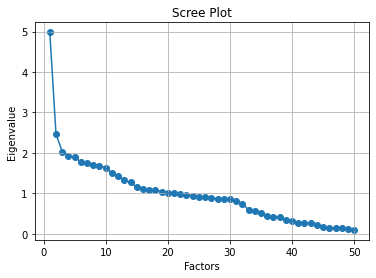

In [20]:
# Create scree plot
plt.scatter(range(1,train_fa.shape[1]+1),ev)
plt.plot(range(1,train_fa.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

In [21]:
 #Create factor analysis object and perform factor analysis
fa = FactorAnalyzer(20, rotation="varimax")
fa.fit(train_fa)

FactorAnalyzer(n_factors=20, rotation='varimax', rotation_kwargs={})

In [ ]:
pd.DataFrame(fa.loadings_, index=train_fa.columns)

In [23]:
# check variance explained 
pd.DataFrame(fa.get_factor_variance(), index=['SS Loadings','Proportion Var','Cumulative Var'])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
SS Loadings,2.791880,2.161488,1.808409,1.753847,1.751982,1.707820,1.561973,1.558389,1.547379,1.530430,1.530411,1.332488,1.304723,1.040649,0.730477,0.631584,0.598330,0.489634,0.450646,0.423882
Proportion Var,0.055838,0.043230,0.036168,0.035077,0.035040,0.034156,0.031239,0.031168,0.030948,0.030609,0.030608,0.026650,0.026094,0.020813,0.014610,0.012632,0.011967,0.009793,0.009013,0.008478
Cumulative Var,0.055838,0.099067,0.135236,0.170312,0.205352,0.239509,0.270748,0.301916,0.332863,0.363472,0.394080,0.420730,0.446824,0.467637,0.482247,0.494879,0.506845,0.516638,0.525651,0.534128


# Modeling Selection

# Model Evaluation

# Model Improvement